# Criteo Uplift v2.1 — Exploratory Analysis

This notebook uses the Parquet dataset produced by the standalone prep script, then performs EDA: schema, missingness, treatment/control balance, outcome rates, and baseline uplift.

Data paths:
- Parquet: `./data/criteo-uplift-v2.1.parquet`

Prerequisite:
- Run: `python src/etl/prepare_dataset.py data/criteo-uplift-v2.1.csv data/criteo-uplift-v2.1.parquet --chunksize 1000000`
- By default, the script auto-downloads from the Criteo page and resolves the direct .csv.gz link: [Criteo Uplift Prediction Dataset](https://ailab.criteo.com/criteo-uplift-prediction-dataset/)


In [ ]:
# Setup
import os
import math
from typing import Dict, List, Optional, Tuple

import pandas as pd
import numpy as np

PARQUET_PATH = "../data/criteo-uplift-v2.1.parquet"


In [2]:
# Data availability check

if not os.path.exists(PARQUET_PATH):
    raise FileNotFoundError(
        "Parquet not found. Please run the standalone converter: \n"
        "python src/etl/prepare_dataset.py data/criteo-uplift-v2.1.csv data/criteo-uplift-v2.1.parquet --chunksize 1000000"
    )
else:
    print({"parquet_found": True, "path": PARQUET_PATH})


{'parquet_found': True, 'path': '../data/criteo-uplift-v2.1.parquet'}


In [3]:
# Load Parquet (required)

df = pd.read_parquet(PARQUET_PATH)
print({"loaded": "parquet", "rows": len(df), "cols": len(df.columns)})


{'loaded': 'parquet', 'rows': 12323845, 'cols': 16}


In [4]:
df.head(3)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616364,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616364,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616364,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


## Dataset fields (from dataset_description.txt)

Expected columns:
- f0..f11: dense float features
- treatment: 1 = treated, 0 = control
- conversion: binary outcome
- visit: binary outcome
- exposure: whether effectively exposed (binary)

Source: [Criteo Uplift Prediction Dataset](https://ailab.criteo.com/criteo-uplift-prediction-dataset/).


In [5]:
# Validate expected columns and basic key figures

expected = set([f"f{i}" for i in range(12)] + ["treatment", "conversion", "visit", "exposure"]) 
missing = sorted(list(expected - set(df.columns)))
extra = sorted(list(set(df.columns) - expected))
print({"missing_expected_columns": missing, "extra_columns_found": extra[:20]})


{'missing_expected_columns': [], 'extra_columns_found': []}


In [6]:
# Compute key figures
rate_visit = df["visit"].mean()
rate_conv = df["conversion"].mean()
tr_ratio = df["treatment"].mean()

{
    "rows": len(df),
    "avg_visit_rate": round(rate_visit, 5),
    "avg_conversion_rate": round(rate_conv, 5),
    "treatment_ratio": round(tr_ratio, 5),
}


{'rows': 12323845,
 'avg_visit_rate': 0.0533,
 'avg_conversion_rate': 0.00331,
 'treatment_ratio': 0.83538}

In [7]:
# Schema and Missingness

print(df.info())

# Memory footprint
mem_mb = df.memory_usage(deep=True).sum() / (1024**2)
print({"memory_mb": round(mem_mb, 2)})

# Missingness summary
nulls = df.isna().sum().sort_values(ascending=False)
nulls_pct = (nulls / len(df) * 100).round(2)
missing_df = pd.DataFrame({"missing": nulls, "missing_pct": nulls_pct})
missing_df.head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12323845 entries, 0 to 12323844
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          Float32
 1   f1          Float32
 2   f2          Float32
 3   f3          Float32
 4   f4          Float32
 5   f5          Float32
 6   f6          Float32
 7   f7          Float32
 8   f8          Float32
 9   f9          Float32
 10  f10         Float32
 11  f11         Float32
 12  treatment   Int8   
 13  conversion  Int8   
 14  visit       Int8   
 15  exposure    Int8   
dtypes: Float32(12), Int8(4)
memory usage: 799.2 MB
None
{'memory_mb': 799.2}


,missing,missing_pct
f0,0,0.0
f1,0,0.0
f2,0,0.0
f3,0,0.0
f4,0,0.0
f5,0,0.0
f6,0,0.0
f7,0,0.0
f8,0,0.0
f9,0,0.0


In [ ]:
# Baseline uplift (difference in means) and CI

tr_col = "treatment"
y_col = "conversion"

outcome = df[y_col]
tr = df[tr_col]

mask = (~outcome.isna()) & (~tr.isna())
outcome = outcome[mask]
tr = tr[mask]

# Binarize if needed (assume >0 means positive)
if sorted(outcome.unique()) not in ([0,1], [0.0,1.0]):
    outcome = (outcome > 0).astype(int)

tr = (tr > 0).astype(int)

p_treat = outcome[tr == 1].mean()
p_ctrl = outcome[tr == 0].mean()
uplift = p_treat - p_ctrl

# Wald CI for difference in proportions
n_t = (tr == 1).sum()
n_c = (tr == 0).sum()
se = math.sqrt(p_treat*(1-p_treat)/n_t + p_ctrl*(1-p_ctrl)/n_c)
z = 1.96
ci_low = uplift - z * se
ci_high = uplift + z * se

{
    "n_treat": int(n_t),
    "n_control": int(n_c),
    "p_treat": round(p_treat, 6),
    "p_control": round(p_ctrl, 6),
    "uplift": round(uplift, 6),
    "ci95": (round(ci_low, 6), round(ci_high, 6))
}


{'n_treat': 10295062,
 'n_control': 2028783,
 'p_treat': 0.003566,
 'p_control': 0.002003,
 'uplift': 0.001563,
 'ci95': (0.001492, 0.001635)}

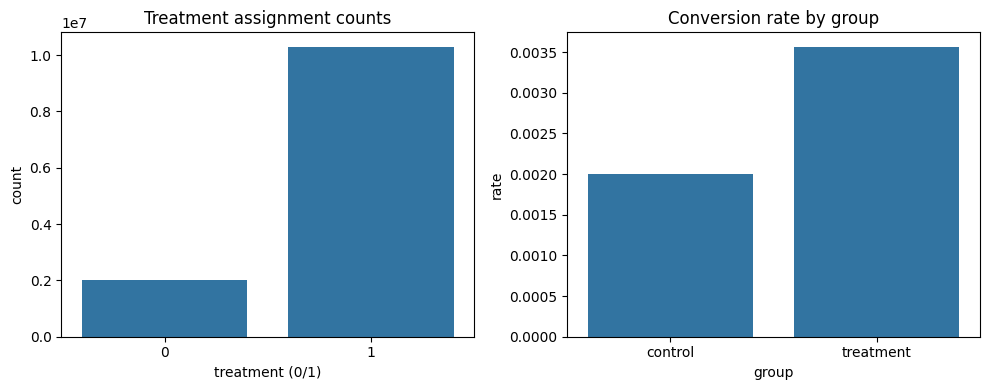

In [10]:
# Simple plots: treatment balance and outcome rates
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(10,4))

sns.countplot(x=tr, ax=axes[0])
axes[0].set_title("Treatment assignment counts")
axes[0].set_xlabel("treatment (0/1)")

rates = pd.DataFrame({
    "group": ["control", "treatment"],
    "rate": [p_ctrl, p_treat]
})
sns.barplot(data=rates, x="group", y="rate", ax=axes[1])
axes[1].set_title("Conversion rate by group")

plt.tight_layout()
plt.show()


In [ ]:
def plot_feature_distributions(df, sample_size: int = 200_000, K: int = 10, random_state: int = 42):
    """
    Plot distributions for top-K numeric and categorical columns using a random sample.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    sample_size : int, default=200_000
        Number of rows to sample for plotting (use None for full dataset).
    K : int, default=10
        Number of numeric and categorical columns to plot.
    random_state : int, default=42
        Random seed for reproducibility.
    """

    # Take sample for speed
    if sample_size is not None and len(df) > sample_size:
        df_sample = df.sample(sample_size, random_state=random_state)
    else:
        df_sample = df.copy()

    # Select columns
    num_cols = [c for c in df_sample.select_dtypes(include=[np.number]).columns][:K]
    cat_cols = [c for c in df_sample.select_dtypes(exclude=[np.number]).columns][:K]

    # Plot numeric features
    if num_cols:
        fig, axes = plt.subplots(len(num_cols), 2, figsize=(10, 4*len(num_cols)))
        if len(num_cols) == 1:  # handle single-column case
            axes = np.array([axes])
        for i, c in enumerate(num_cols):
            sns.histplot(df_sample[c], bins=50, ax=axes[i,0], element="step", color="steelblue")
            axes[i,0].set_title(f"{c} distribution")
            sns.boxplot(x=df_sample[c], ax=axes[i,1], color="orange")
            axes[i,1].set_title(f"{c} boxplot")
        plt.tight_layout()
        plt.show()

    # Plot categorical features
    if cat_cols:
        for c in cat_cols:
            plt.figure(figsize=(8,3))
            vc = df_sample[c].astype(str).value_counts().head(20)
            sns.barplot(x=vc.values, y=vc.index, color="steelblue")
            plt.title(f"Top categories for {c}")
            plt.tight_layout()
            plt.show()


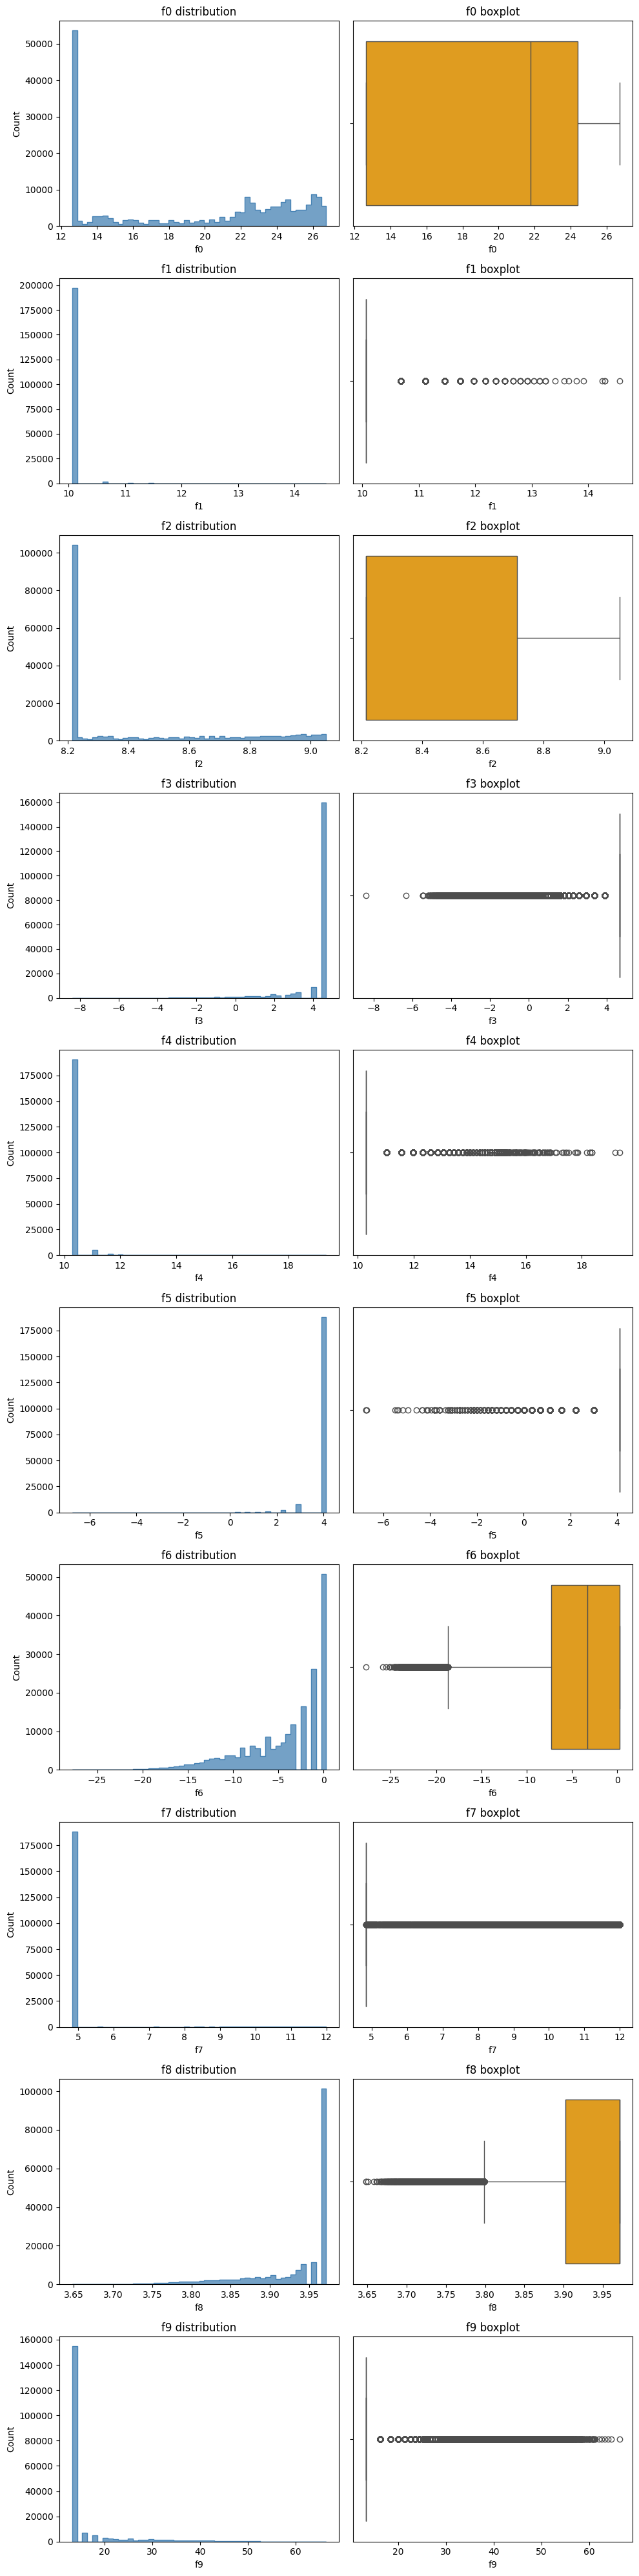

In [12]:
plot_feature_distributions(df)

In [ ]:
from scipy import stats

def check_balance(
    df: pd.DataFrame,
    tr_col: str,
    features: List[str],
    sample_size: int = 50_000,
    random_state: int = 42
) -> pd.DataFrame:
    """
    Check balance between treatment and control groups using Kolmogorov–Smirnov tests.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing treatment column and features.
    tr_col : str
        Column name for treatment indicator (0/1).
    features : list of str
        Feature column names to check balance for.
    sample_size : int, default=50_000
        Number of rows per group to sample for speed. If a group has fewer rows,
        the full group is used.
    random_state : int, default=42
        Random seed for reproducibility.
        
    Returns
    -------
    pd.DataFrame
        Balance diagnostics with KS statistic and p-value per feature.
    """
    results = []
    
    # Sample treatment and control groups
    t_df = df[df[tr_col] == 1].sample(
        n=min(sample_size, df[tr_col].sum()),
        random_state=random_state
    )
    c_df = df[df[tr_col] == 0].sample(
        n=min(sample_size, (df[tr_col] == 0).sum()),
        random_state=random_state
    )
    
    for c in features:
        t_vals = t_df[c].dropna()
        c_vals = c_df[c].dropna()
        if len(t_vals) > 0 and len(c_vals) > 0:
            ks_stat, p_val = stats.ks_2samp(t_vals, c_vals)
            results.append({"feature": c, "ks_stat": ks_stat, "p_value": p_val})
    
    return pd.DataFrame(results).set_index("feature").sort_values("ks_stat", ascending=False)


In [28]:
features = [f"f{i}" for i in range(12)]
balance_df = check_balance(df, tr_col="treatment", features=features, sample_size=50_000)

#balance_df


Balance diagnostics show small but systematic imbalances across treatment and control groups. Features f6, f8, and f3 have KS ≈ 0.03–0.05, indicating the distributions differ by up to 5%. This suggests that treatment assignment is not perfectly random, motivating the use of backdoor adjustment methods (e.g., propensity scores or causal ML) to obtain unbiased treatment effect estimates.

In [29]:
def summarize_balance(balance_df, thresholds=(0.01, 0.05)):
    """
    Summarize balance diagnostics by categorizing KS statistics.

    Parameters
    ----------
    balance_df : pd.DataFrame
        DataFrame with columns ["ks_stat", "p_value"], indexed by feature.
    thresholds : tuple, default=(0.01, 0.05)
        Thresholds for categorizing imbalance:
        - < thresholds[0]: negligible
        - thresholds[0]–thresholds[1]: moderate
        - > thresholds[1]: large

    Returns
    -------
    pd.DataFrame
        Balance summary with added 'imbalance_level'.
    """
    t1, t2 = thresholds
    def categorize(ks):
        if ks < t1:
            return "Negligible"
        elif ks < t2:
            return "Moderate"
        else:
            return "Large"

    summary = balance_df.copy()
    summary["imbalance_level"] = summary["ks_stat"].apply(categorize)
    return summary.sort_values("ks_stat", ascending=False)

summary = summarize_balance(balance_df)
summary


,ks_stat,p_value,imbalance_level
feature,,,
f6,0.04978,2.800762e-54,Moderate
f8,0.04002,3.155347e-35,Moderate
f3,0.03116,1.598916e-21,Moderate
f9,0.02580,6.876371e-15,Moderate
f2,0.01918,2.026032e-08,Moderate
f0,0.01880,4.170609e-08,Moderate
f7,0.01170,2.113731e-03,Moderate
f5,0.01168,2.163764e-03,Moderate
f10,0.00680,1.970400e-01,Negligible


In [15]:
balance_df.to_json()

'{"ks_stat":{"f6":0.04978,"f8":0.04002,"f3":0.03116,"f9":0.0258,"f2":0.01918,"f0":0.0188,"f7":0.0117,"f5":0.01168,"f10":0.0068,"f4":0.00674,"f1":0.004,"f11":0.00202},"p_value":{"f6":2.800762099e-54,"f8":3.15534713e-35,"f3":1.59891599e-21,"f9":0.0,"f2":0.0000000203,"f0":0.0000000417,"f7":0.0021137313,"f5":0.0021637641,"f10":0.1970399813,"f4":0.2051912784,"f1":0.8170622525,"f11":0.9999526577}}'

In [16]:
def plot_balance_distributions(
    df, 
    tr_col: str, 
    features: list, 
    balance_df: pd.DataFrame, 
    top_k: int = 3, 
    bins: int = 50, 
    sample_size: int = 200_000, 
    random_state: int = 42
):
    """
    Plot distributions of the most imbalanced features (by KS statistic)
    between treatment and control groups, with optional subsampling.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with treatment column and features.
    tr_col : str
        Name of treatment indicator column (0/1).
    features : list of str
        Candidate features to plot.
    balance_df : pd.DataFrame
        Output of `check_balance` with ks_stat values per feature.
    top_k : int, default=3
        Number of most imbalanced features to plot.
    bins : int, default=50
        Number of histogram bins.
    sample_size : int, default=200_000
        Number of rows to sample for plotting. If None, use full dataset.
    random_state : int, default=42
        Random seed for reproducibility.
    """
    # Subsample for speed
    if sample_size is not None and len(df) > sample_size:
        df = df.sample(sample_size, random_state=random_state)

    # Pick top-k imbalanced features
    top_feats = balance_df.sort_values("ks_stat", ascending=False).head(top_k).index.tolist()

    for f in top_feats:
        plt.figure(figsize=(8,4))
        sns.histplot(df.loc[df[tr_col]==1, f], bins=bins, color="steelblue", 
                     label="Treatment", stat="density", alpha=0.6)
        sns.histplot(df.loc[df[tr_col]==0, f], bins=bins, color="orange", 
                     label="Control", stat="density", alpha=0.6)
        plt.title(f"Distribution of {f} by treatment status\n(KS={balance_df.loc[f,'ks_stat']:.3f})")
        plt.legend()
        plt.tight_layout()
        plt.show()


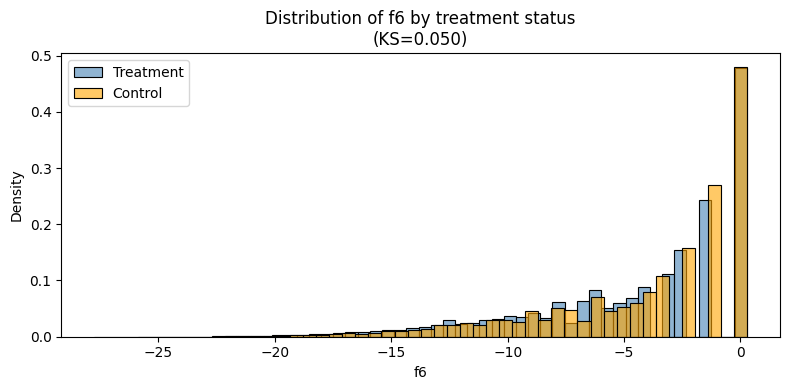

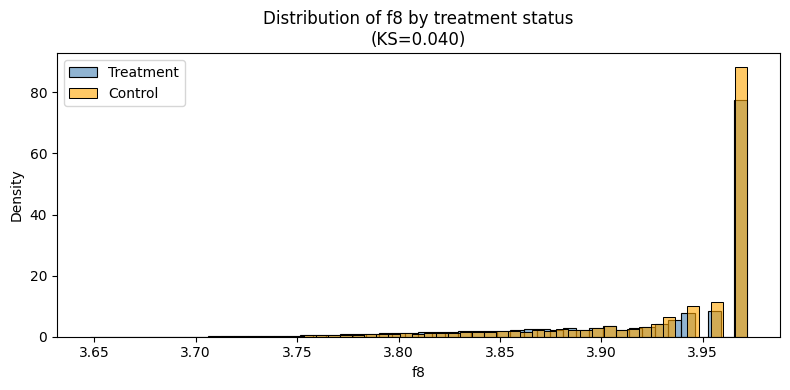

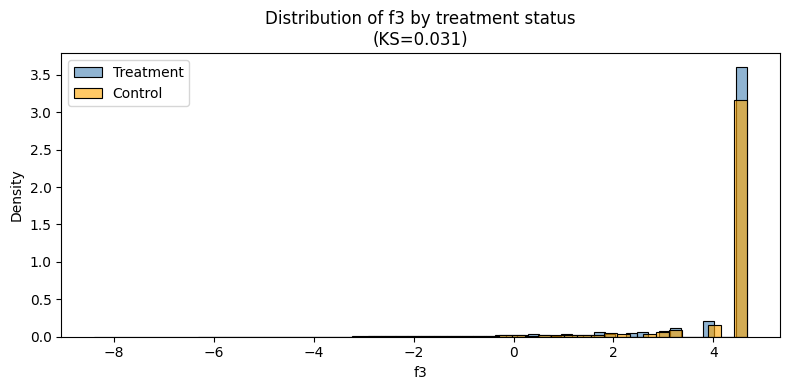

In [17]:
plot_balance_distributions(df, tr_col="treatment", features=[f"f{i}" for i in range(12)], balance_df=balance_df, top_k=3)


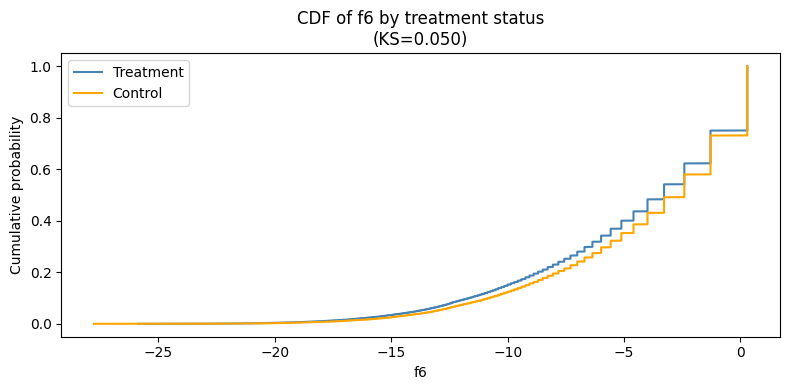

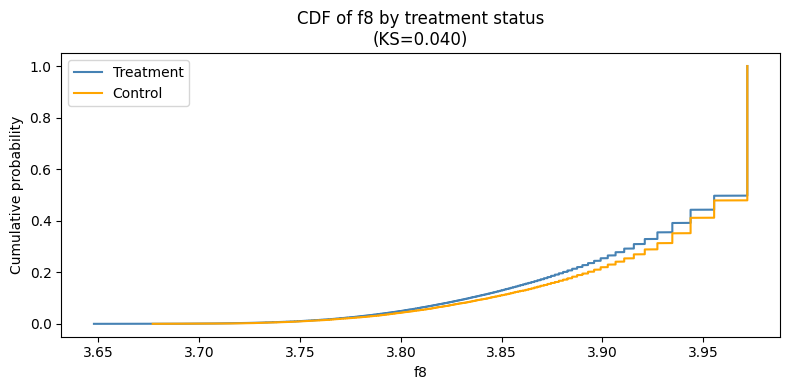

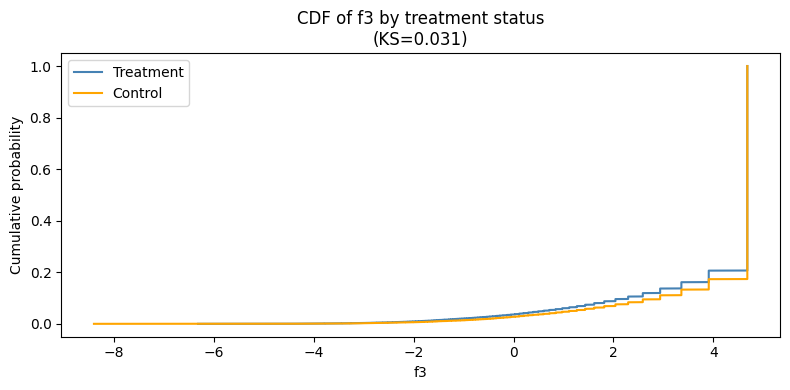

In [31]:
def plot_balance_cdfs(
    df, 
    tr_col: str, 
    features: list, 
    balance_df: pd.DataFrame, 
    top_k: int = 3, 
    sample_size: int = 200_000, 
    random_state: int = 42
):
    """
    Plot CDFs of the most imbalanced features (by KS statistic)
    between treatment and control groups, with optional subsampling.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with treatment column and features.
    tr_col : str
        Name of treatment indicator column (0/1).
    features : list of str
        Candidate features to plot.
    balance_df : pd.DataFrame
        Output of `check_balance` with ks_stat values per feature.
    top_k : int, default=3
        Number of most imbalanced features to plot.
    sample_size : int, default=200_000
        Number of rows to sample for plotting. If None, use full dataset.
    random_state : int, default=42
        Random seed for reproducibility.
    """
    # Subsample for speed
    if sample_size is not None and len(df) > sample_size:
        df = df.sample(sample_size, random_state=random_state)

    # Pick top-k imbalanced features
    top_feats = balance_df.sort_values("ks_stat", ascending=False).head(top_k).index.tolist()

    for f in top_feats:
        plt.figure(figsize=(8,4))
        
        # CDF for treatment
        t_vals = np.sort(df.loc[df[tr_col]==1, f].dropna())
        t_cdf = np.arange(1, len(t_vals)+1) / len(t_vals)
        plt.plot(t_vals, t_cdf, label="Treatment", color="steelblue")
        
        # CDF for control
        c_vals = np.sort(df.loc[df[tr_col]==0, f].dropna())
        c_cdf = np.arange(1, len(c_vals)+1) / len(c_vals)
        plt.plot(c_vals, c_cdf, label="Control", color="orange")
        
        plt.title(f"CDF of {f} by treatment status\n(KS={balance_df.loc[f,'ks_stat']:.3f})")
        plt.xlabel(f)
        plt.ylabel("Cumulative probability")
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_balance_cdfs(df, tr_col="treatment", features=[f"f{i}" for i in range(12)], balance_df=balance_df)

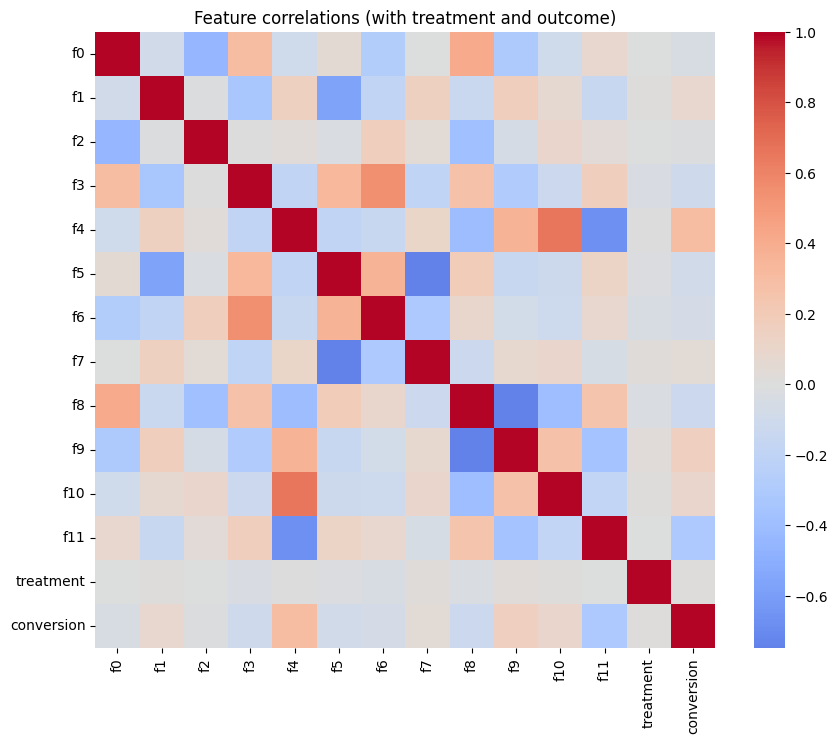

In [18]:
corr = df[[f"f{i}" for i in range(12)] + [tr_col, y_col]].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature correlations (with treatment and outcome)")
plt.show()


In [32]:
def significant_correlations(corr_df, threshold=0.1):
    """
    Print feature pairs with correlation magnitude above threshold.

    Parameters
    ----------
    corr_df : pd.DataFrame
        Correlation matrix (square DataFrame).
    threshold : float, default=0.1
        Absolute correlation cutoff to consider as "significant".
    """
    results = []
    cols = corr_df.columns
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            val = corr_df.iloc[i, j]
            if abs(val) >= threshold:
                results.append((cols[i], cols[j], round(val, 3)))
    # Sort by absolute correlation
    results.sort(key=lambda x: abs(x[2]), reverse=True)
    return results

corr = df[[f"f{i}" for i in range(12)] + [tr_col, y_col]].corr()
sig_corrs = significant_correlations(corr, threshold=0.1)

for a, b, val in sig_corrs:
    print(f"{a} vs {b}: {val}")


f8 vs f9: -0.748
f5 vs f7: -0.745
f4 vs f11: -0.678
f4 vs f10: 0.657
f1 vs f5: -0.574
f3 vs f6: 0.544
f0 vs f2: -0.453
f0 vs f8: 0.411
f4 vs f8: -0.409
f8 vs f10: -0.402
f2 vs f8: -0.381
f9 vs f11: -0.362
f4 vs f9: 0.361
f5 vs f6: 0.359
f3 vs f5: 0.329
f1 vs f3: -0.328
f6 vs f7: -0.317
f11 vs conversion: -0.312
f0 vs f9: -0.309
f0 vs f3: 0.299
f4 vs conversion: 0.298
f3 vs f9: -0.292
f0 vs f6: -0.27
f3 vs f8: 0.267
f9 vs f10: 0.264
f8 vs f11: 0.252
f3 vs f7: -0.197
f3 vs f4: -0.195
f4 vs f5: -0.194
f5 vs f8: 0.193
f1 vs f6: -0.191
f10 vs f11: -0.184
f1 vs f9: 0.171
f3 vs f11: 0.169
f2 vs f6: 0.168
f9 vs conversion: 0.155
f4 vs f6: -0.152
f5 vs f9: -0.152
f1 vs f7: 0.149
f1 vs f11: -0.149
f1 vs f4: 0.148
f1 vs f8: -0.14
f7 vs f8: -0.132
f3 vs f10: -0.13
f8 vs conversion: -0.13
f5 vs f10: -0.124
f5 vs f11: 0.12
f6 vs f10: -0.115
f4 vs f7: 0.109
f3 vs conversion: -0.103


Correlation analysis reveals strong multicollinearity among certain features (e.g., f8–f9, f5–f7), suggesting redundancy. More importantly, several features that are imbalanced between treatment and control (f3, f6, f8) are also correlated with conversion. This confirms their role as potential confounders and reinforces the need for causal adjustment (e.g., propensity score methods or causal ML) to estimate unbiased treatment effects.

/tmp/ipykernel_57347/1422555579.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg_rates = df.groupby(["f0_bin", tr_col])[y_col].mean().unstack()


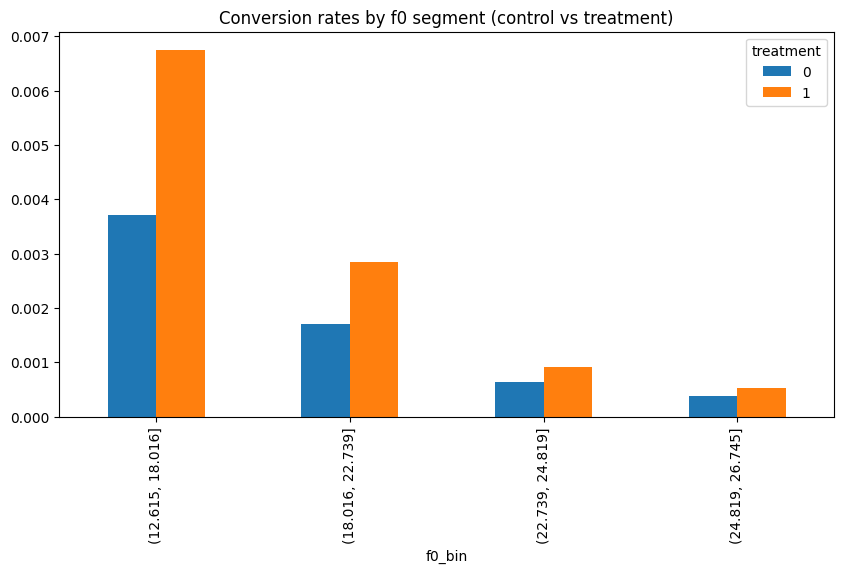

In [19]:
df["f0_bin"] = pd.qcut(df["f0"], q=5, duplicates="drop")
seg_rates = df.groupby(["f0_bin", tr_col])[y_col].mean().unstack()
seg_rates.plot(kind="bar", figsize=(10,5))
plt.title("Conversion rates by f0 segment (control vs treatment)")
plt.show()


### Causal DAG

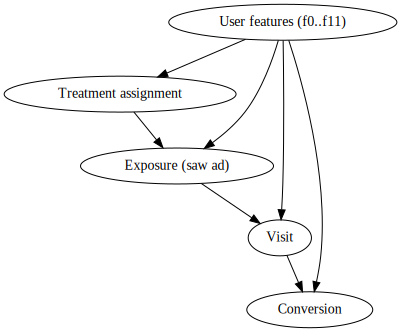

In [23]:
from graphviz import Digraph

def plot_causal_dag():
    dot = Digraph(comment="Criteo Uplift DAG", format="png")
    
    # Nodes
    dot.node("F", "User features (f0..f11)")
    dot.node("T", "Treatment assignment")
    dot.node("E", "Exposure (saw ad)")
    dot.node("V", "Visit")
    dot.node("Y", "Conversion")
    
    # Edges (causal arrows)
    dot.edge("T", "E")
    dot.edge("E", "V")
    dot.edge("V", "Y")
    
    # Confounding
    dot.edge("F", "T")
    dot.edge("F", "E")
    dot.edge("F", "V")
    dot.edge("F", "Y")
    
    return dot

dag = plot_causal_dag()
#dag.render("dag_criteo", view=True)  # saves and opens as PNG
dag
